__Integrantes__ : Andryel Hiyoshi Onoue (RA: 1904559)

# 01 - Definição do Problema e Entendimento do Negócio

### 01.1 - Entendimento do Contexto
    Em financeiras, a retenção de clientes é uma métrica crítica para o sucesso de negócio. A taxa de rotatividade ou "churn"  representa a porcentagem de clientes que deixam o serviço dentro de um determinado período. Um modelo que possa prever quais clientes estão mais propensos a deixar a empresa pode ajudar a implementar estratégias proativas de retenção, minimizando a perda de receita e maximizando o valor do ciclo de vida do cliente.

### 01.3 - Descrição do Problem
* __Churn__: Refere-se a quando um cliente ou assinante cessa o relacionamento com a empresa.
    
* __Impacto__: Prever quais clientes irão cessar o relacionamento com o banco e diminuir a vazão de clientes através de campanhas de boa relação
    
### 01.2 - Objetivos
* Definir perfil de churn de clientes;
* Transmitir os dados de forma objetiva
* Montar modelo preditivo com 90% de acurácia
    
### 01.3 - Identificação das Variáveis: Listar variáveis dependentes e independentes relevantes para o modelo.
* __Variável Dependente:__
    * Saida: É a variável alvo que indica se um cliente saiu ou não da empresa (1 para saída, 0 para retenção).
* __Variáveis Independentes:__
    * PontuacaoDeCredito: Pontuação de crédito do cliente.
    * Geografia: País de residência.
    * Genero: Sexo do cliente.
    * Idade: Idade do cliente.
    * TempoDeRelacionamento: Número de anos que o cliente está com a empresa.
    * Saldo: Saldo bancário do cliente.
    * NumeroDeProdutos: Número de produtos que o cliente utiliza.
    * TemCartaoDeCredito: Se o cliente tem um cartão de crédito (1 para sim, 0 para não).
    * MembroAtivo: Se o cliente é um membro ativo (1 para sim, 0 para não).
    * SalarioEstimado: Salário estimado do cliente.

# 02 - Coleta de Dados

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



dados = pd.read_csv('../input/Churn_Modelling.csv', delimiter=',')
dados = dados.drop(columns=['CustomerId','Surname','RowNumber'],axis=1)
dados.columns =  ['PontuacaoDeCredito', 'Geografia', 'Genero', 'Idade','TempoDeRelacionamento', 'Saldo', 'NumeroDeProdutos','TemCartaoDeCredito',
                  'MembroAtivo', 'SalarioEstimado', 'Saida']

# 03 - Exploração e Preparação dos Dados

### 03.1 - Análise Exploratória de Dados (EDA)

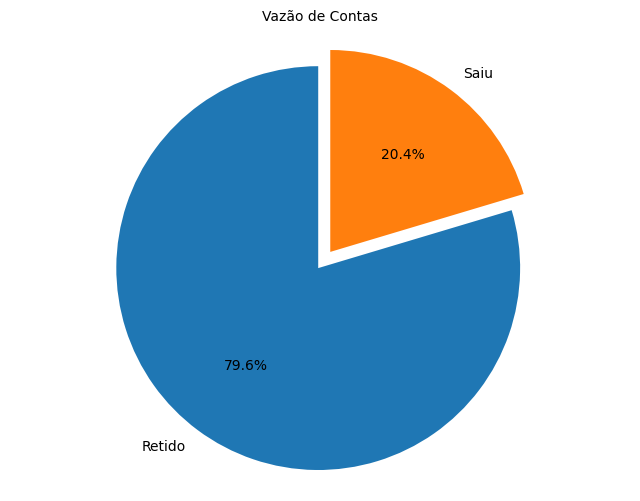

In [2]:
labels = 'Retido','Saiu'
sizes = [dados.Saida[dados['Saida']==0].count(),dados.Saida[dados['Saida']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6))

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

ax1.axis('equal')
plt.title("Vazão de Contas", size = 10)
plt.show()

#### __Observações Sobre Churn__
O gráfico mostra que 30% dos clientes não sairam do banco, enquanto os outros 70% estão retidos.

__- Pontos Positivos__ :

* __Taxa de Retenção__: Podemos observar inicialmente que a taxa de retenção é positiva.
    + Pode ser interessante realizar uma analise temporal onde é verificado contas abertas e fechadas e suas caracteristicas.
* __Base para Comparação__: Saber esses números oferece um ponto de partida para futuras análise de retenção e é relevante para estratégias de melhorias.

__- Áreas de Preocupação__ :

* __Alta Taxa de Churn__ : Um churn de 30% é considerável e merece certa atenção. É crucial entender por que e quem são os clientes que estão saindo.
* __Impacto Financeiro__ : O churn de 30% pode ter um impacto financeiro significativo a longo prazo. Seria útil calcular o impacto e se vale a pena recuperar esses clientes ou variar os perfis de serviços.

__- Áreas de Investigação__ :

* __Segmentação dos Clientes__
    + Possuem algum produto ativo?
* __Ciclo de Vida__
    + As contas são fechadas no OnBoarding ou após certo período de tempo?
    + Possuem algum saldo em conta?
* __Retenção de valor__
    + Os clientes que saem possuem muito recurso?
* __Análise Geográfica__
    + O Churn está concentrado em alguma região específica?


__- Óticas que podem ser importantes__ :

* __Razões de Churn__
    + Verificar motivo da saída
    + Verificar últimos produtos consumidos
    + Verificar momento financeiro e motivo de abertura de conta
* __Eficácia das Campanhas__
    + A partir das métricas obtidas, entender o impacto de futuras camapanhas



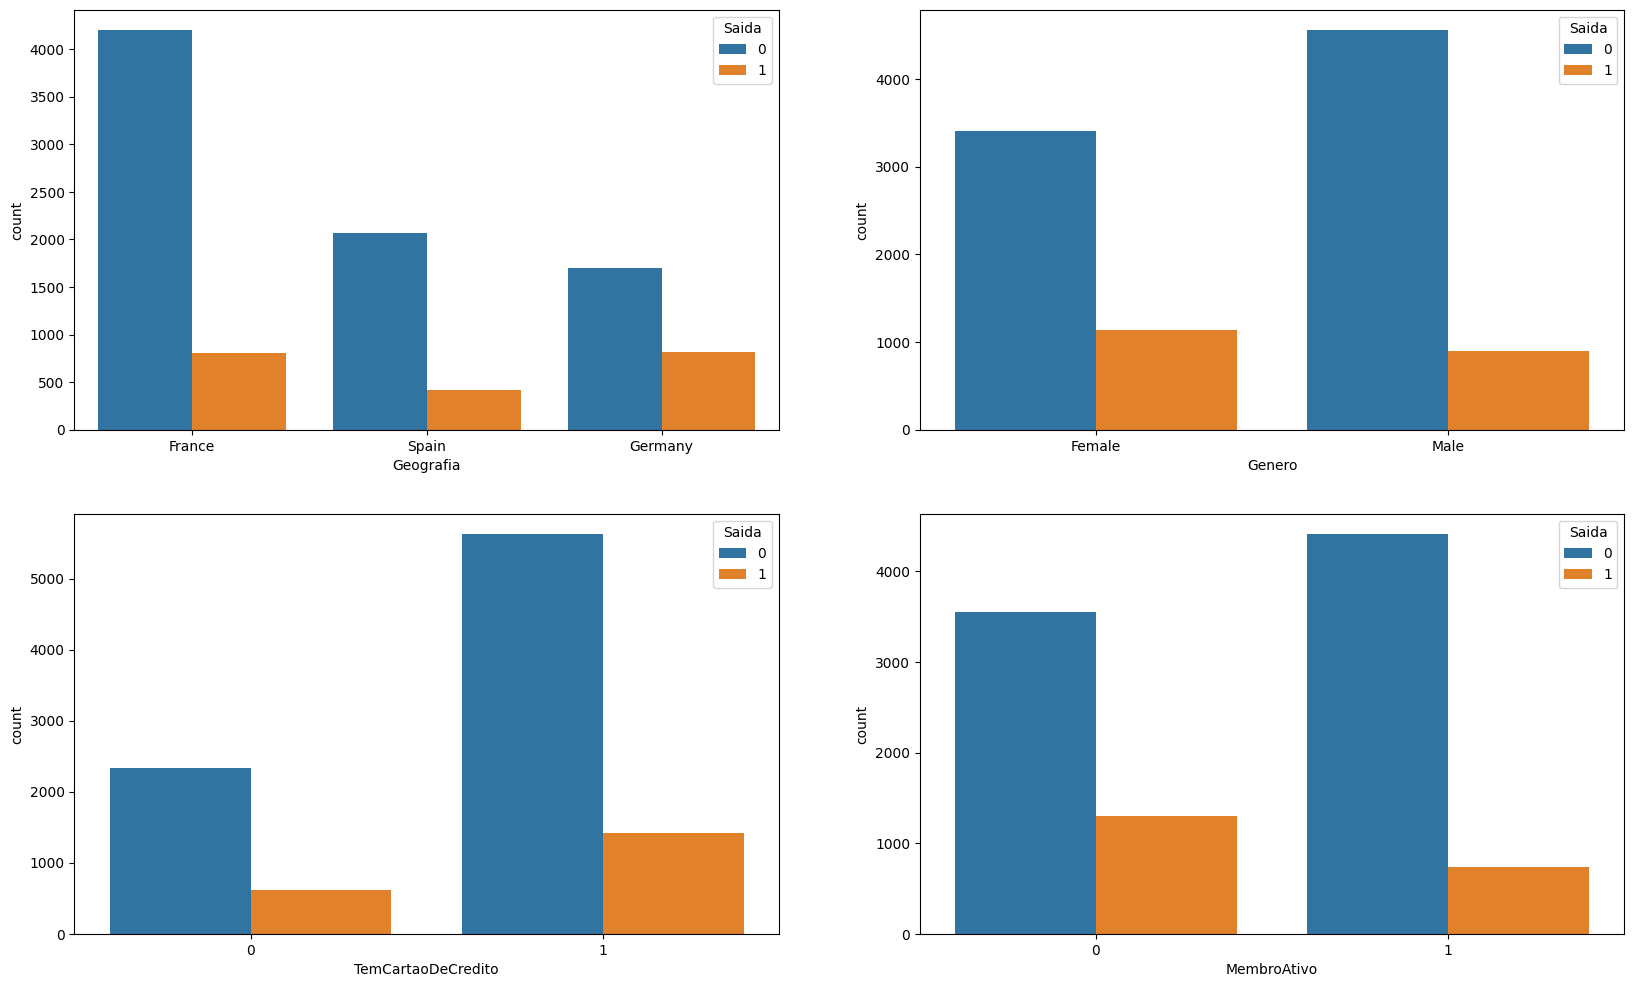

In [3]:
# Variáveis Categóricas
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geografia', hue = 'Saida',data = dados, ax=axarr[0][0])
sns.countplot(x='Genero', hue = 'Saida',data = dados, ax=axarr[0][1])
sns.countplot(x='TemCartaoDeCredito', hue = 'Saida',data = dados, ax=axarr[1][0]);
sns.countplot(x='MembroAtivo', hue = 'Saida',data = dados, ax=axarr[1][1]);

__- Perguntas Levantadas__ :

* __Segmentação dos Clientes__
    + Possuem algum produto ativo?
        * R: A maior parte possui cartão de crédito, porém não são membros ativos.
* __Análise Geográfica__
    + O Churn está concentrado em alguma região específica?
        * R: O Churn é maior na França e Alemanha.

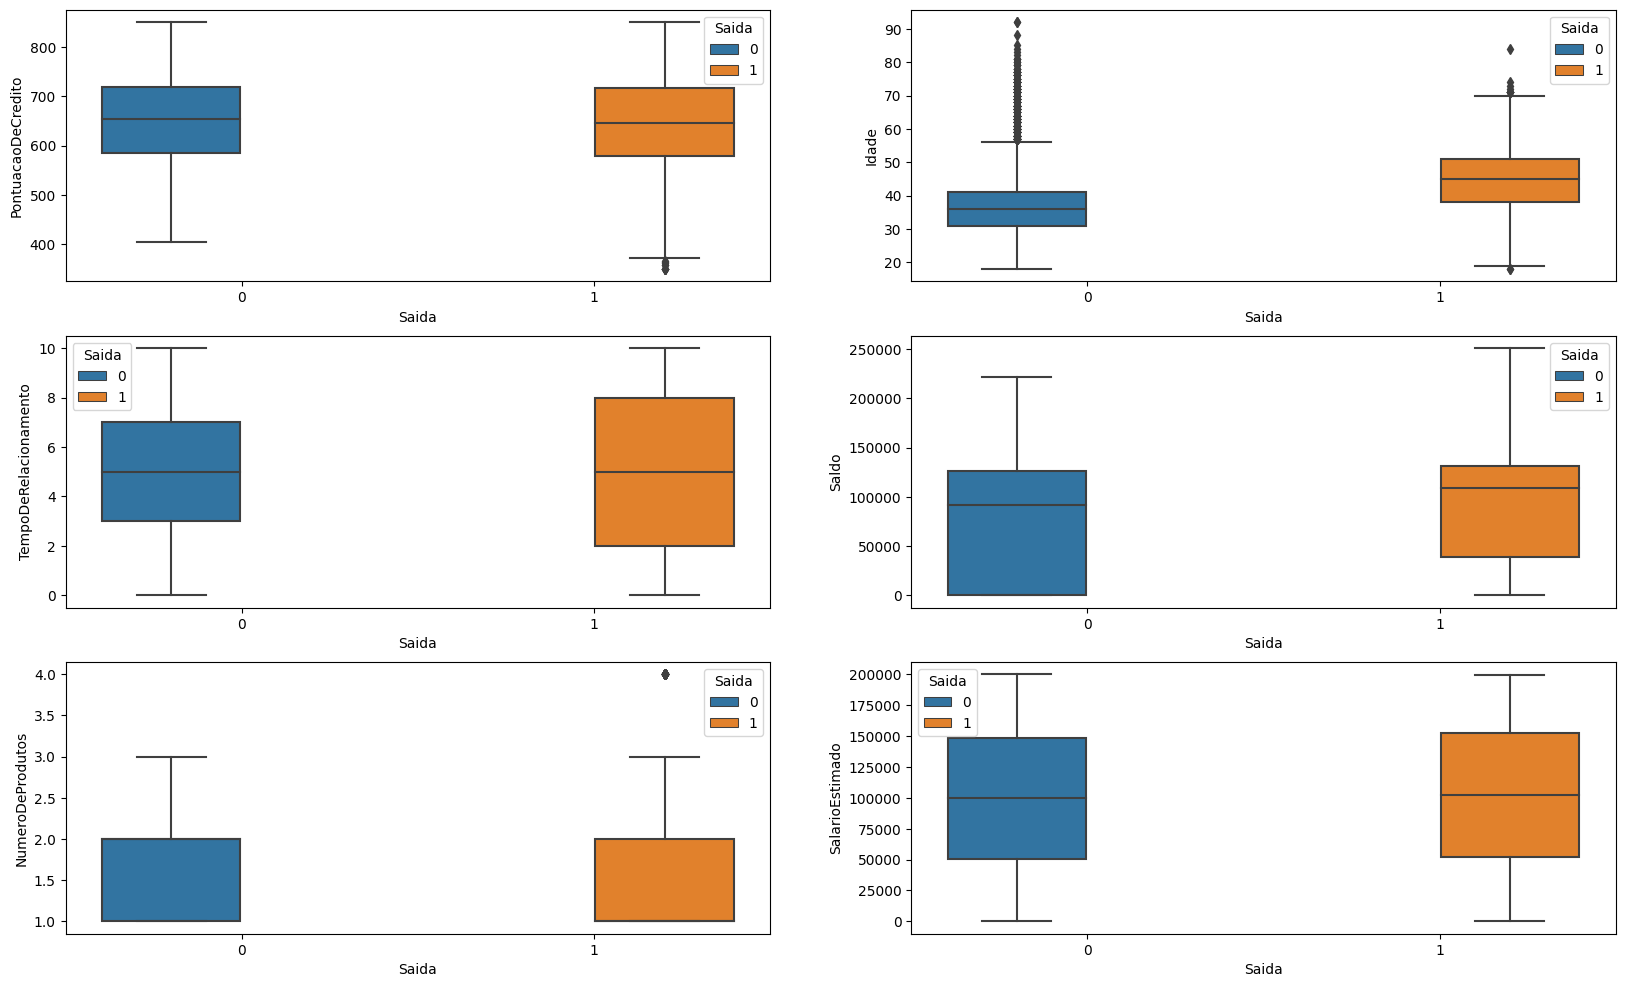

In [4]:
# Variáveis Numéricas
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='PontuacaoDeCredito',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[0][0]);
sns.boxplot(y='Idade',x = 'Saida', hue = 'Saida',data = dados , ax=axarr[0][1]);
sns.boxplot(y='TempoDeRelacionamento',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[1][0]);
sns.boxplot(y='Saldo',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[1][1]);
sns.boxplot(y='NumeroDeProdutos',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[2][0]);
sns.boxplot(y='SalarioEstimado',x = 'Saida', hue = 'Saida',data = dados, ax=axarr[2][1]);

__- Perguntas Levantadas__ :


* __Ciclo de Vida__
    + As contas são fechadas no OnBoarding ou após certo período de tempo?
        * R: O tempo de relacionamento comum de fechamento está concentrado entre 2-8 anos. (Estou levando em consideração anos na variável)
    + Possuem algum saldo em conta?
        * R: A concentração de saída possui entre 50mil - 100mil de Saldo em suas contas
* __Retenção de valor__
    + Os clientes que saem possuem muito recurso?
        * R: Sim, e também salário relativamente altos
            * Pode ser considerado utilizar uma variavel relacionando ambos

### 03.2 - Limpeza de Dados
* Desconsiderada, por não ser possível conferir os dados inseridos

### 03.3 - Codificação de Variáveis Categóricas

#### 03.3.1 - One Hot Encoding

In [5]:
### One-Hot Encoding -> Técnica usada em variaveis categoricas para serem fornecidas a modelos de machine learning.
    ## Nesse caso iremos tratar primeiro as variáveis com textos e depois as numéricas
    ## Será usado -1 ao invés do 0 para ajudar os modelos a capturarem relações negativas mais facilmente

dados = pd.get_dummies(dados, columns=['Geografia', 'Genero', 'TemCartaoDeCredito', 'MembroAtivo'], drop_first=True)

#### 03.3.2 - One Hot Encoding

In [6]:
# Logaritmica -> técnica estatística comum que visa normalizar a distribuição dos dados e reduzir o impacto de outliers.
dados['NumeroDeProdutos'] = dados['NumeroDeProdutos'].apply(lambda x: np.log(x))
dados['Saldo'] = dados['Saldo'].apply(lambda x: np.log(x + 1))

In [7]:
# Separando features e target
X = dados.drop('Saida', axis=1)
y = dados['Saida']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizando as variáveis
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balanceamento de classes com SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Criando o modelo XGBoost
xgb = XGBClassifier()

# Parâmetros para Random Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Otimização de hiperparâmetros com Random Search
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, cv=3)
random_search.fit(X_resampled, y_resampled)

# Melhor modelo
best_xgb = random_search.best_estimator_

# Treinando o melhor modelo
best_xgb.fit(X_resampled, y_resampled)

# Fazendo as previsões
y_pred = best_xgb.predict(X_test)

# Calculando as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC: {roc_auc}')


Accuracy: 0.812
Precision: 0.5150976909413855
Recall: 0.7379134860050891
ROC AUC: 0.7840158593684439


## Com base nos resultados das métricas de desempenho apresentadas, temos:

* __Acurácia__: 81.8% - Indica uma performance geral sólida.
* __Precisão__: 52.63% - Mostra que o modelo possui alguma tendência em identificar falsos positivos.
* __Recall__: 73.79% - Sugere que o modelo é eficiente em identificar a classe de interesse.
* __Área sob a curva ROC (AUC-ROC)__: 78.77% - Este valor sugere que o modelo tem uma capacidade razoável de distinguir entre as classes positiva e negativa.

## Sugestões
    * Aprofundamento no negócio para entender quais features podem ser criadas.
    * Revisar a Otimização de Hiperparametros.
    * Realizar avalidação cruzada para obter outras estimativas do desempenho do modelo.


## Conclusão Final:
    O desempenho do modelo é promissor, especialmente em termos de acurácia e recall. A acurácia nos mostra que o modelo acerta mais de 80% das vezes, o que é uma métrica forte para qualquer modelo. O alto recall sugere que o modelo é efetivo na detecção de verdadeiros positivos, o que pode ser crucial dependendo do contexto de negócios.

    Entretanto, a precisão moderada do modelo indica que a identificação de falsos positivos pode ser um ponto de melhoria. O valor de AUC-ROC também sugere que o modelo tem um poder discriminatório aceitável, mas há espaço para aprimoramentos.
    
    Assim, enquanto o modelo oferece insights valiosos, ele também aponta para áreas que podem ser aprimoradas em iterações futuras, possivelmente através de ajuste de hiperparâmetros, balanceamento de classes, ou exploração de modelos mais sofisticados.